In [1]:
!pip install tf-keras openpyxl seaborn transformers

In [4]:
# Import all the required libraries
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
nltk.download('stopwords')
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WinTo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [6]:
# Create dataframe for final sentiment classification result
def createDataFrame(labels, confidence, tweet):
    labels = pd.DataFrame({'Labels': labels})
    confidence = pd.DataFrame({'Confidence Scores': confidence})
    column_values = ['Labels', 'Confidence']
    sentiment_scores = pd.concat([labels,confidence], ignore_index=False, axis=1)
    print(sentiment_scores.to_string(index=False))

In [7]:
def sentiment_test(tweet):
    labels = []
    confidence = []
    
    # Possible Sentiment Categories
    candidate_labels = ["happy", "sad", "warn", "angry", "sorrow", "alert", "neutral"]
    
    # Send the labels and tweets to the classifier pipeline
    result = classifier(tweet, candidate_labels)
    
    # Extract the labels from results dictionary
    labels.append(result["labels"])
    labels = [item for sublist in labels for item in sublist] # Flatten the list of lists into list
    
    # Extract the labels from results dictionary
    confidence.append(result["scores"])
    confidence = [(str(float(item)*100))[:6]+" %" for sublist in confidence for item in sublist] # Flatten the list of lists into list

    createDataFrame(labels,confidence, tweet)

In [ ]:
sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'
sentiment_test(sample_1)
    
sample_2 = 'I am happy that my family members are safe in this tough times'
sentiment_test(sample_2)

 Labels Confidence Scores
   warn          51.956 %
  alert          26.361 %
    sad          12.751 %
 sorrow          4.9466 %
  angry          3.1605 %
neutral          0.5962 %
  happy          0.2266 %
 Labels Confidence Scores
  happy          76.314 %
  alert          17.165 %
   warn          3.8741 %
neutral          1.7418 %
 sorrow          0.3840 %
    sad          0.3506 %
  angry          0.1697 %


In [8]:
# Load the transfer learning tweet dataset
sentiment_df = pd.read_csv('twitterdata.csv')

In [9]:
# Checking if NVIDIA Graphics Card and CUDA is available
gpu_available = torch.cuda.is_available

if gpu_available:
    print('Parallely Processing using CUDA')
else:
    print('No CUDA Detected')

Parallely Processing using CUDA


In [10]:
# Pre-process the text and perform Stemming, Lemmatization and Stop-word removal
def text_preprocessing(text):
    remove_punctuation = [ch for ch in text if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_text


# Pad blank token to keep the length of tweets consistent - mandatory to normalize and train the model
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)
    for i, row in enumerate(reviews_int):
        if len(row)!=0:
            features[i, -len(row):] = np.array(row)[:seq_length]
    return features

# Convert the sentences into stream of tokens
#def tokenize(tweet):
#    test_ints = []
#    test_ints.append([vocab_to_int[word] for word in tweet])
#    return test_ints

def tokenize(tweet):
    test_ints = []
    # Add an entry for unknown words
    vocab_to_int['<UNK>'] = 0  # Assuming 0 is not used, adjust based on your indexing
    # Tokenize the tweet, use vocab_to_int[word] if word is in vocab_to_int, else use vocab_to_int['<UNK>']
    test_ints.append([vocab_to_int[word] if word in vocab_to_int else vocab_to_int['<UNK>'] for word in tweet])
    return test_ints

# Predict the sentiment of the tweet - performs binary classification using the model inference
def sentiment(net, test_tweet, seq_length=50):
    
    print("\n--------------------------------------------------------------------------------------")
    print(f"\n Original input sentence: {test_tweet}")
    
    
    print(f"\n Pre-processed input sentence: {test_tweet}")
    #print(f"\nSentence converted into tokens:\n{tokenized_tweet}")

    results = {"Original": [], "Processed": [], "Sentiment": []}
    word_collection = {"Positive": [], "Negative": []}
    
    for tweets in test_tweet:
        original_tweet = tweets
        processed_tweet = text_preprocessing(tweets) 
        tokenized_tweet = tokenize(processed_tweet) 
        padded_tweet = pad_features(tokenized_tweet, seq_length)
        feature_tensor = torch.from_numpy(padded_tweet)
        
        if gpu_available:
            feature_tensor = feature_tensor.cuda()
        
        batch_size = feature_tensor.size(0)
        h = net.init_hidden(batch_size)
        output, h = net(feature_tensor, h)
        predicted_sentiment = torch.round(output.squeeze())
        
        sentiment = "Positive" if predicted_sentiment.item() == 1 else "Negative"
        results["Original"].append(original_tweet)
        results["Processed"].append(processed_tweet)
        results["Sentiment"].append(sentiment)
        word_collection[sentiment].extend(processed_tweet) 

    return results, word_collection

In [11]:
# Code block to invoke Pre-processing, Padding and Tokenization operations on the tweet

sentiment_df.loc[:, 'text'] = sentiment_df['text'].apply(text_preprocessing)

reviews_split = []
for i, j in sentiment_df.iterrows():
    reviews_split.append(j['text'])

words = []
for review in reviews_split:
    for word in review:
        words.append(word)

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word:ii for ii, word in enumerate(vocab, 1)}

encoded_reviews = []
for review in reviews_split:
    encoded_reviews.append([vocab_to_int[word] for word in review])

labels_to_int = []
for i, j in sentiment_df.iterrows():
    if j['sentiment']=='joy':
        labels_to_int.append(1)
    else:
        labels_to_int.append(0)

reviews_len = Counter([len(x) for x in encoded_reviews])
non_zero_idx = [ii for ii, review in enumerate(encoded_reviews) if len(encoded_reviews)!=0]
encoded_reviews = [encoded_reviews[ii] for ii in non_zero_idx]
encoded_labels = np.array([labels_to_int[ii] for ii in non_zero_idx])

seq_length = 50
padded_features= pad_features(encoded_reviews, seq_length)

In [12]:
# Split the dataset into Train (80%), Validation (10%) & Test (10%)
batch_size = 1
split_frac = 0.8
split_idx = int(len(padded_features)*split_frac)

training_x, remaining_x = padded_features[:split_idx], padded_features[split_idx:]
training_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

# Transform the data into a Tensor datastructure
train_data = TensorDataset(torch.from_numpy(training_x), torch.from_numpy(training_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# Prepare the dataloader for Train, Test and Validation
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

In [13]:
# Embedding Dimension of Tokens
embedding_dim = 400

# Embedding Dimension of Hidden Layers
hidden_dim = 256

# Output of the model is binary (either Positive or Negative)
output_size = 1

# Number of hidden LSTM cells
n_layers = 2
vocab_size = len(vocab_to_int)+1

In [14]:
# Structure of the Neural Network
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding_layer(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        if gpu_available:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero())
        return hidden

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

In [15]:
# Hyperparameters required for training of the network

# Learning Rate
lr = 0.001

# Loss Function - Binary Cross Entropy
criterion = nn.BCELoss()

# Gradient Descent based Optimizer - ADAM (Adaptive LR)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Number of epochs to train the model
epochs = 8
count = 0

# Step size
print_every = 200
clip = 5 

In [16]:
import torch
print(torch.__version__)


2.2.2+cu121


In [17]:
print(torch.cuda.is_available())

True


C:\Users\WinTo\AppData\Local\Temp\ipykernel_21352\4120411337.py:26: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/8..... Step: 200..... Train Loss: 0.082167...... Validation Loss: 0.079324
Epoch: 1/8..... Step: 400..... Train Loss: 0.074136...... Validation Loss: 0.112323
Epoch: 1/8..... Step: 600..... Train Loss: 0.075745...... Validation Loss: 0.413640
Epoch: 1/8..... Step: 800..... Train Loss: 0.767235...... Validation Loss: 0.974374
Epoch: 1/8..... Step: 1000..... Train Loss: 0.047509...... Validation Loss: 0.043843
Epoch: 1/8..... Step: 1200..... Train Loss: 0.805077...... Validation Loss: 0.262581
Epoch: 1/8..... Step: 1400..... Train Loss: 0.037878...... Validation Loss: 0.234175
Epoch: 1/8..... Step: 1600..... Train Loss: 0.542245...... Validation Loss: 0.597794
Epoch: 1/8..... Step: 1800..... Train Loss: 0.006238...... Validation Loss: 0.635627
Epoch: 1/8..... Step: 2000..... Train Loss: 0.173179...... Validation Loss: 0.443987
Epoch: 1/8..... Step: 2200..... Train Loss: 0.060199...... Validation Loss: 0.136623
Epoch: 1/8..... Step: 2400..... Train Loss: 0.092501...... Validation

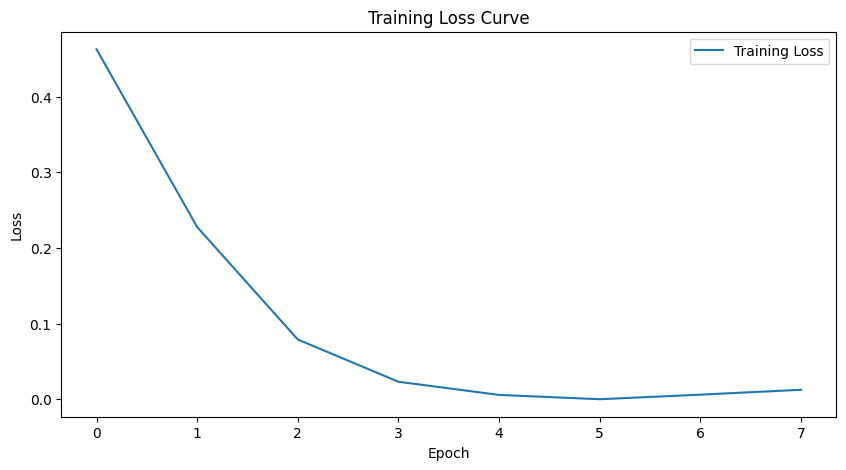

In [18]:
import matplotlib.pyplot as plt

# Train the Neural Network
# Off-load the model to CUDA
if gpu_available:
    net.cuda()
losses = []
net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)

    running_loss = 0.0

    for inputs, labels in train_loader:
        count += 1
        
        if gpu_available:
            inputs, labels = inputs.cuda(), labels.cuda()
        h = tuple([each.data for each in h])
        
        net.zero_grad()
        outputs, h = net(inputs, h)
        loss = criterion(outputs.float(), labels.float())
        
        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()

        running_loss += loss.item()

        if count % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                
                if gpu_available:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.float(), labels.float())
            val_losses.append(val_loss.item())
        
            net.train()
            print(f"Epoch: {e+1}/{epochs}.....",f"Step: {count}.....","Train Loss: {:.6f}......".format(loss.item()),"Validation Loss: {:.6f}".format(np.mean(val_losses)))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {e+1}/{epochs} - Loss: {epoch_loss:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
#save model
torch.save(net.state_dict(), 'lstm_sklearn.pth')

Average Test Loss: 0.9901
Average Test Accuracy: 0.8867


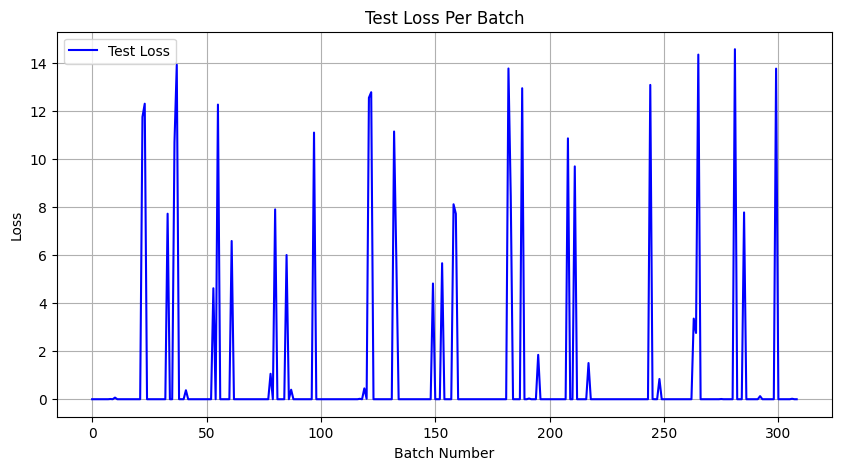

In [19]:

test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)
net.eval()

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    
    if gpu_available:
        inputs, labels = inputs.cuda(), labels.cuda()
    
    outputs, h = net(inputs, h)
    test_loss = criterion(outputs.float(), labels.float())
    test_losses.append(test_loss.item())
    
    pred = torch.round(outputs.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


test_acc = num_correct/len(test_loader.dataset)

print("Average Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Average Test Accuracy: {:.4f}".format(test_acc))

plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Test Loss', color='blue')
plt.title('Test Loss Per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
print(sentiment_df.columns)


Index(['Unnamed: 0', 'sentiment', 'text'], dtype='object')


In [21]:
unique_sentiments = sentiment_df['sentiment'].unique()
for sentiments in unique_sentiments:
    print(sentiments)

sad
joy
fear
anger


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [ ]:
correctness = {'correct': 0, 'incorrect': 0}

# If your sentiment labels are not exactly 'positive' or 'negative', define a mapping
label_mapping = {
    'joy': 'positive',
    'sad': 'negative',
    'anger': 'negative',
    'fear': 'negative'
}

# Update the sentiment_df with mapped labels for comparison
sentiment_df['mapped_sentiment'] = sentiment_df['sentiment'].map(label_mapping)

# Iterate over each tweet
for index, row in sentiment_df.iterrows():
    tweet = row['text']
    true_sentiment = row['mapped_sentiment']
    
    # If your sentiment function expects a list, make sure to pass a list even if it's one tweet
    result, word_collection = sentiment(net, [tweet])
    
    # Now we check if any sentiments were returned
    if result['Sentiment']:
        predicted_sentiment = result['Sentiment'][0].lower()  # assuming the sentiment is the first item
        correct = predicted_sentiment == true_sentiment
    else:
        # If no sentiments were returned, we cannot say if it's correct or not, so we mark it as incorrect for now
        predicted_sentiment = None
        correct = False

    # Update our correctness dictionary
    if correct:
        correctness['correct'] += 1
    else:
        correctness['incorrect'] += 1

accuracy = correctness['correct'] / (correctness['correct'] + correctness['incorrect'])
print(f'Overall accuracy: {accuracy:.2%}')


--------------------------------------------------------------------------------------

 Original input sentence: [['agree', 'poor', 'india', 'treated', 'badly', 'poors', 'seek', 'living', 'singapore', 'treated', 'like', 'citizens', 'given', 'free', 'medical', 'treatment', 'given', 'food', 'daily', 'sim', 'cards', 'call', 'home', 'tell', 'family', 'fine', 'covid', '19', 'case', 'treated', 'foc', 'hospitals']]

 Pre-processed input sentence: [['agree', 'poor', 'india', 'treated', 'badly', 'poors', 'seek', 'living', 'singapore', 'treated', 'like', 'citizens', 'given', 'free', 'medical', 'treatment', 'given', 'food', 'daily', 'sim', 'cards', 'call', 'home', 'tell', 'family', 'fine', 'covid', '19', 'case', 'treated', 'foc', 'hospitals']]

--------------------------------------------------------------------------------------

 Original input sentence: [['could', 'spent', 'cutie', 'vc', 'sakshis', 'n', 'g', 'h', 'coast', 'crossing', 'republik', '…']]

 Pre-processed input sentence: [['could

In [ ]:
# Initialize the word collection
word_collection = {'Positive': [], 'Negative': []}

# Process each tweet and aggregate the words for each sentiment
for tweet in sentiment_df['text']:
    # Here we're assuming `sentiment` is a function that takes a tweet and returns a result
    # The result is expected to have two keys 'Positive' and 'Negative', each associated with a list of words
    result, temp_word_collection = sentiment(net, tweet)

    # We're extending the respective lists of 'Positive' and 'Negative' words in our word_collection
    word_collection['Positive'].extend(temp_word_collection['Positive'])
    word_collection['Negative'].extend(temp_word_collection['Negative'])

# After processing all tweets, generate word clouds
for sentiments in ['Positive', 'Negative']:
    # Join the words using a space to ensure they are separated
    words = ' '.join(word_collection[sentiments])
    if not words:  # If there are no words, skip to the next iteration
        print(f"No words to display for {sentiments} sentiment.")
        continue
    
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiments} Words')
    plt.axis('off')
    plt.show()


--------------------------------------------------------------------------------------

 Original input sentence: ['agree', 'poor', 'india', 'treated', 'badly', 'poors', 'seek', 'living', 'singapore', 'treated', 'like', 'citizens', 'given', 'free', 'medical', 'treatment', 'given', 'food', 'daily', 'sim', 'cards', 'call', 'home', 'tell', 'family', 'fine', 'covid', '19', 'case', 'treated', 'foc', 'hospitals']

 Pre-processed input sentence: ['agree', 'poor', 'india', 'treated', 'badly', 'poors', 'seek', 'living', 'singapore', 'treated', 'like', 'citizens', 'given', 'free', 'medical', 'treatment', 'given', 'food', 'daily', 'sim', 'cards', 'call', 'home', 'tell', 'family', 'fine', 'covid', '19', 'case', 'treated', 'foc', 'hospitals']

--------------------------------------------------------------------------------------

 Original input sentence: ['could', 'spent', 'cutie', 'vc', 'sakshis', 'n', 'g', 'h', 'coast', 'crossing', 'republik', '…']

 Pre-processed input sentence: ['could', 'spe

KeyboardInterrupt: 

In [ ]:
def read_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read().strip().split('\n')

def sentiment_analysis_accuracy(net, data):
    correct_predictions = 0
    total_predictions = len(data)

    for tweet in data:
        # Assuming sentiment function returns a tuple with the result being the first item
        result, _ = sentiment(net, tweet)
        # Assuming result['Sentiment'] contains the list of predicted sentiments
        # Adjust based on your function's return structure
        if result['Sentiment']:
            predicted_sentiment = result['Sentiment'][0].lower()
            if predicted_sentiment == "positive":
                correct_predictions += 1
        else:
            # Handle cases where no prediction is returned
            print(f"No sentiment returned for: {tweet}")

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

# Replace 'path_to_hm_sample.txt' with your actual file path
data = read_dataset('hm_sample.txt')
accuracy = sentiment_analysis_accuracy(net, data)
print(f"Accuracy of the model on the new positive dataset: {accuracy:.2%}")


--------------------------------------------------------------------------------------

 Original input sentence: Today took my pet to vet clinic and came to know she was carrying, so excited and surprised for my fur baby.

 Pre-processed input sentence: Today took my pet to vet clinic and came to know she was carrying, so excited and surprised for my fur baby.

--------------------------------------------------------------------------------------

 Original input sentence: I found a new aerobic at the gym, it was pulling a rope, sitting down, I was so happy because I burned 240 calories in 16 minutes

 Pre-processed input sentence: I found a new aerobic at the gym, it was pulling a rope, sitting down, I was so happy because I burned 240 calories in 16 minutes

--------------------------------------------------------------------------------------

 Original input sentence: The best moment when I won dota2 championship

 Pre-processed input sentence: The best moment when I won dota2 ch

In [ ]:
def load_dataset_from_excel(file_path):
    # Load the dataset from an Excel file
    df = pd.read_excel(file_path)
    return df['sentence']  # Assuming 'sentence' is the column with text data

def sentiment_analysis_on_dataset(net, data):
    correct_predictions = 0
    total_predictions = len(data)

    for sentence in data:
        # Assuming sentiment function returns a tuple with the result being the first item
        result, _ = sentiment(net, sentence)
        # Assuming result['Sentiment'] contains the list of predicted sentiments
        # Adjust based on your function's return structure
        if result['Sentiment']:
            predicted_sentiment = result['Sentiment'][0].lower()
            if predicted_sentiment == "negative":  # Since all sentences are expected to be sad/negative
                correct_predictions += 1
        else:
            # Handle cases where no prediction is returned
            print(f"No sentiment returned for: {sentence}")

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

# Load data from Excel file
data = load_dataset_from_excel('SAD_v1.xlsx')
# Compute the accuracy of sentiment predictions
accuracy = sentiment_analysis_on_dataset(net, data)
print(f"Accuracy of the model on the negative dataset: {accuracy:.2%}")


--------------------------------------------------------------------------------------

 Original input sentence: ?

 Pre-processed input sentence: ?

--------------------------------------------------------------------------------------

 Original input sentence: 2 of my foster kittens died

 Pre-processed input sentence: 2 of my foster kittens died

--------------------------------------------------------------------------------------

 Original input sentence: A better question would be what is not stressing me out.

 Pre-processed input sentence: A better question would be what is not stressing me out.

--------------------------------------------------------------------------------------

 Original input sentence: a big project at work.

 Pre-processed input sentence: a big project at work.

--------------------------------------------------------------------------------------

 Original input sentence: a certain person at work is being really angry with me lately.

 Pre-processe

KeyboardInterrupt: 

In [23]:
import torch

In [24]:
model = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.load_state_dict(torch.load('lstm_sklearn.pth'))

<All keys matched successfully>

In [25]:
# set model to eval mode
model.eval()

LSTM(
  (embedding_layer): Embedding(10663, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [26]:
all_preds = []
all_labels = []

# Ensure the model is on the right device and set to evaluation mode
model = net  # Ensure this is the trained model instance
model.eval()  # Set the model to evaluation mode to disable dropout, etc.

if gpu_available:
    model.cuda()  # Move model to GPU if available
else:
    model.cpu()  # Ensuring model is on CPU if GPU is not available

# Prediction loop
for inputs, labels in test_loader:
    h = model.init_hidden(batch_size)

    # Move inputs and labels to the same device as the model
    if gpu_available:
        inputs, labels = inputs.cuda(), labels.cuda()
    else:
        inputs, labels = inputs.cpu(), labels.cpu()
    
    outputs, h = model(inputs, h)
    preds = torch.round(outputs.squeeze())

    # Detach the predictions and move back to CPU for collecting, if they are on GPU
    # Ensure preds and labels are in array form even if they're scalar
    preds = preds.detach().cpu().numpy()
    preds = preds.flatten()  # Ensure it is a 1D array, safe if already 1D
    all_preds.extend(preds)
    labels = labels.cpu().numpy()
    labels = labels.flatten()  # Similarly ensure labels are 1D
    all_labels.extend(labels)


In [27]:
# preds to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

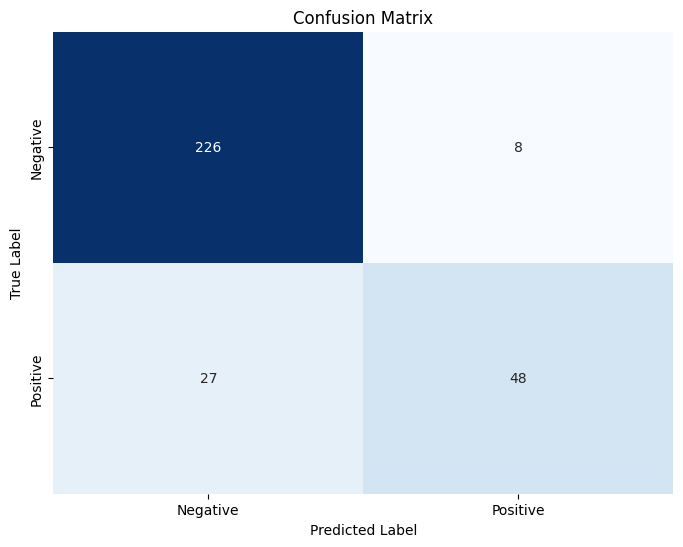

In [28]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
class_rep = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_rep)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.96      0.93       234
    Positive       0.84      0.65      0.74        75

    accuracy                           0.89       309
   macro avg       0.87      0.81      0.83       309
weighted avg       0.88      0.89      0.88       309

